# Odvisnost temperature razlike in pretoka v toplovodu
Določiti želimo pretok v ceveh na podlagi časovnega zamika pri širjenju temperaturnega profila med dvema merilnima mestoma, kjer se meri temperatura vode. 

In [1]:
# knjižnice, ki jih potrebujemo
%pylab
import pandas as pd

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# podatki o temperaturah 
temp_1 = pd.read_csv("MurEF_T1.csv",index_col="Time",delimiter=";")
#temp_2 = pd.read_csv("MUR_EF.csv",delimiter=";")

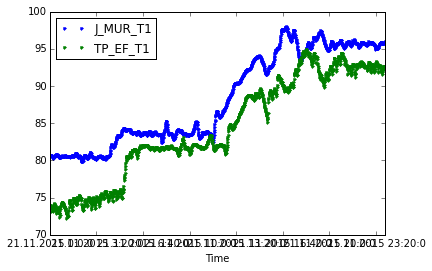

In [3]:
%matplotlib inline
temp_1.plot(style=".",ylim=[70,100])

In [4]:
s1 = temp_1.TP_EF_T1
s2 = temp_1.J_MUR_T1

(80, 100)

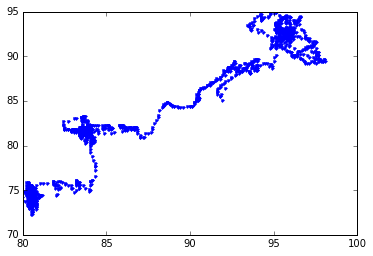

In [5]:
T1T2 = temp_1.as_matrix()
T1 = T1T2[:,0]
T2 = T1T2[:,1]
plot(T1,T2,'.')
xlim([80,100])

## Določitev časovnega zamika

Če na isti graf narišemo potek temperatur na obeh merilnih mestih, vidimo, da sta grafa zamaknjena. Iz podatkov o temperaturi na začetnem $T_0(t)$ in končnem merilnem mestu $T_k(t)$, bi radi določili časovni zamik $\tau$. Časovni zamik poiščemo z naslednjim postopkom.

 * Izberemo „časovno okno“, to je časovni interval $[t,t+\delta t]$
 * za različne vrednosti $\tau$, izračunamo korelacijski koeficient med signalom $T_0$ na $[t,t+\delta t]$ in signalom $T_k$ na intervalu $[t+\tau,t+\delta t +\tau]$
 $$\rho(T_0(T),T_k(t+\tau)\text{ na }[t,t+\delta t].$$
 * iskani časovni zamik je tisti, pri katerem je korelacija največja
 $$\tau_m = \max_{\tau}\rho(T_0(t),T_k(t+\tau))$$

In [8]:
def opt_zamik(T1,T2,t,dt,plot_graph=False):
    """Izračuna zamik tau, pri katerem sta obe časovni vrsti najbolj poravnani."""
    okno = arange(dt)
    m = 0
    tau_m = 0
    tau_list = range(40,120)
    r_list = []
    for tau in tau_list:
        r = corrcoef(T1[okno+t],T2[okno+tau+t])[0,1]
        r_list.append(r)
        if r>m:
            tau_m = tau
            m = r
    r_list = array(r_list)
    tv = sum(abs(r_list[1:]-r_list[:-1]))/len(tau_list)        
    rp = average(r_list)
    if plot_graph:
        fig = plt.figure(figsize=(12, 4))
        subplot(121)
        plot(tau_list,r_list,'.')
        plot(tau_list,rp*ones(len(tau_list)),'r-')
        xlabel("časovni zamik $\\tau$")
        ylabel("korelacijski koef. $\\rho(T_0(t),T_k(t+\\tau))$")
        plot([tau_m,tau_m],[-1,m],'ro-',)
        annotate("$\\tau_m$",xy = [tau_m+0.5,-0.9])
        title("$\\rho(T_0(t),T_k(t+\\tau))$ v odvisnosti od $\\tau$")
        subplot(122)
        plot(okno+t,T1[okno+t],label="$T_0(t)$")
        plot(okno+t,T2[okno+tau_m+t],label="$T_k(t+%d)$"%tau_m)
        xlabel("čas $t$ v minutah")
        ylabel("temperatura T v °C")
        title("$T_0(t)$ in $T_k(t+\\tau)$")
        legend()
    return (tau_m,m,rp,tv)


(71, 0.9533294654158796, -0.084723610516932266, 0.050036692305754249)

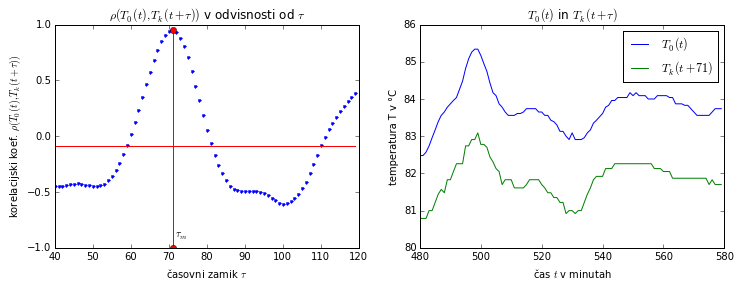

In [9]:
opt_zamik(T1,T2,480,100,plot_graph=True)

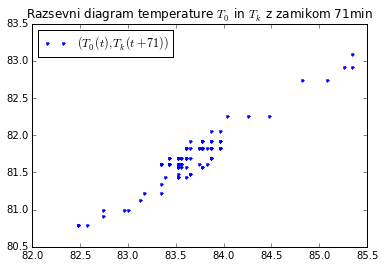

In [17]:
okno = arange(100)
t = 400
tau = 71
plot(T1[t+okno],T2[t+okno+tau],'.',label="$(T_0(t),T_k(t+%d))$"%tau)
legend(loc=2)
title("Razsevni diagram temperature $T_0$ in $T_k$ z zamikom %dmin"%tau)

62 0.943427826435 0.519195885061 0.0237147622093


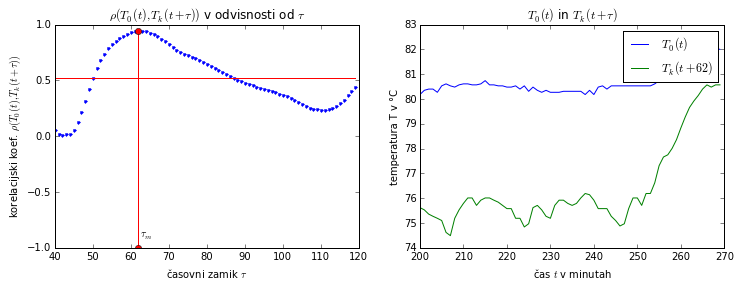

In [10]:
from ipywidgets import interact
@interact(t=(1,1200,20),dt=(50,150))
def zamik(t=200,dt=70):
    tau,r,rp,tv = opt_zamik(T1,T2,t,dt,plot_graph=True)
    print(tau,r,rp,tv)

## Omejitve
Če tempraturna odvisnost nima značilnih oblik, časovnega zamika $\tau$  ni mogoče zanesljivo določiti. Vrednost $\tau$, pri katerem je korelacijski koeficient maksimalen, je precej občutljiv na šum. V tem primeru je korelacijski koeficient skoraj neodvisen od $\tau$ in je povprečen $\rho$ velik. 

(88, 0.97876089239830222, 0.78523955553921942, 0.013007957879135895)

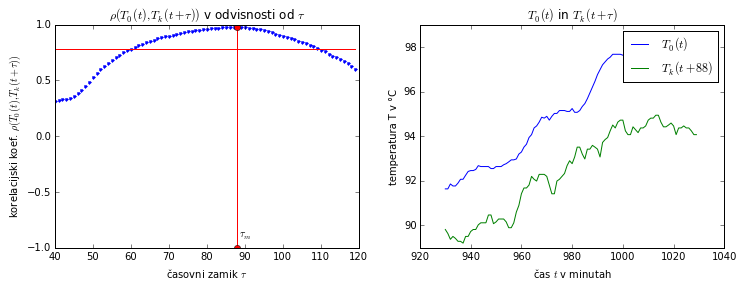

In [11]:
opt_zamik(T1,T2,930,100,plot_graph=True)

Drug primer, ko časovnega zamika ne moremo zanesljivo določiti, če temperatura niha. V tem primeru je več možnih kandidatov. Povprečen korelacijski koeficient $\rho$ je sicer blizu nič, vendar pa je totalna variacija v tem primeru velika.

(73, 0.68536965221466317, 0.02326388079652169, 0.093028930335482304)

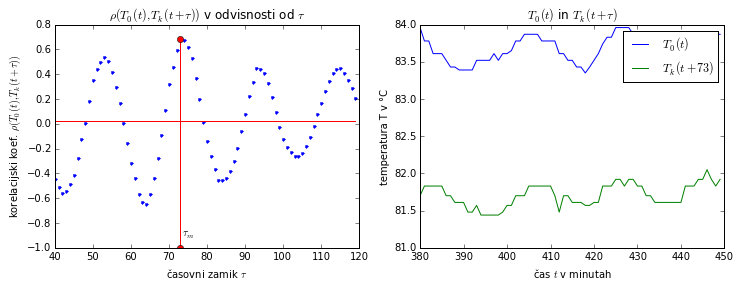

In [12]:
opt_zamik(T1,T2,380,70,plot_graph=True)

## Rezultati

In [13]:
dt = 70
tau_list = []
t_list = []
for t in range(1250):
    tau,r,rp,tv = opt_zamik(T1,T2,t,dt)
    if r>0.8 and rp<0.1: # and tv<0.06 and tv>0.04:
        tau_list.append((tau,r,rp,tv)) 
        t_list.append(t)
tau_m = array(tau_list)

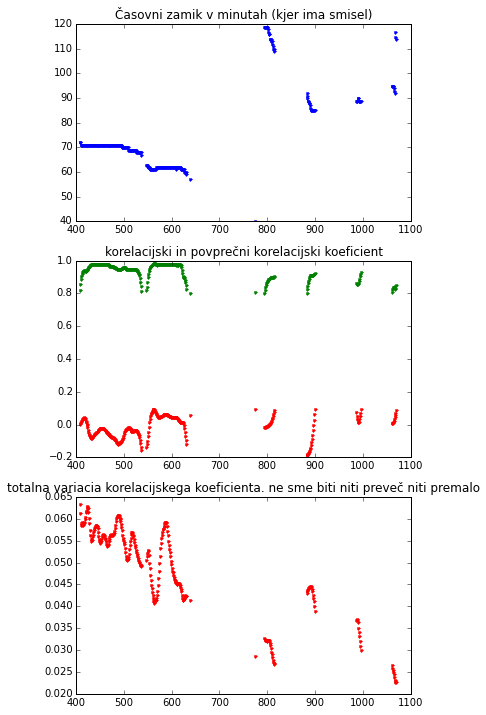

In [14]:
figure(figsize=(6,12))
subplot(311)
plot(t_list,tau_m[:,0],'.')
title("Časovni zamik v minutah (kjer ima smisel)")
subplot(312)
plot(t_list,tau_m[:,1],'.g')
plot(t_list,tau_m[:,2],'.r')
title("korelacijski in povprečni korelacijski koeficient")
subplot(313)
plot(t_list,tau_m[:,3],'.r')
title("totalna variacia korelacijskega koeficienta. ne sme biti niti preveč niti premalo")